# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

###
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/pituitary_tumor/' # Class as 4

#import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset


In [2]:
# read image
indx=0
images = []
labels = []

labels_index = 0

print('Sample of normal images in data:')
for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, 0))
    labels_index = idx

normal_index = labels_index + 1

for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, 1))
    labels_index = idx

glioma_index = normal_index + labels_index + 1

for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, 2))
    labels_index = idx

meningioma_index = glioma_index + labels_index + 1

for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, 3))

Sample of normal images in data:


In [3]:
labels = np.array(labels)

In [4]:
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'Label'])

In [5]:
labels_df['Label'].value_counts()

2    923
1    901
3    844
0    438
Name: Label, dtype: int64

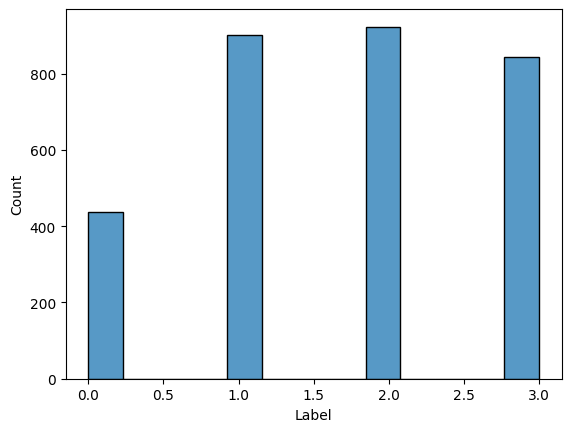

In [6]:
# histogram
sns.histplot(
    data=labels_df,
    stat="count",
    x = "Label"
);

## Split Images Datasets

`Correct for data imbalance`

In [7]:
np.random.seed(1234)

n_size = 80

normal = labels_df[labels_df['Label'] == 0]
glioma = labels_df[labels_df['Label'] == 1]
meningioma = labels_df[labels_df['Label'] == 2]
pituitary = labels_df[labels_df['Label'] == 3]

# randomly draw 400 images from each classes
temp_normal = list(np.random.choice(
    normal.img_num,
    size=n_size,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma.img_num,
    size=n_size,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma.img_num,
    size=n_size,
    replace=False
))


temp_pituitary = list(np.random.choice(
    pituitary.img_num,
    size=n_size,
    replace=False
))

In [8]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [9]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  320
Length of Labels List:  320


In [10]:
images_mini = []
y_mini = []

for img in image_list:

# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)

images_mini = np.stack(images_mini)

for label in labels_list:
    y_mini.append(label[1])

y_mini = np.array(y_mini)

In [11]:
images_mini.shape

(320, 256, 256, 3)

In [12]:
y_mini.shape

(320,)

In [13]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 256, 256, 1)
y_train shape (192,)
X_val shape (64, 256, 256, 1)
y_val shape (64,)
X_test shape (64, 256, 256, 1)
y_test shape (64,)


In [15]:
validate_split = pd.DataFrame(y_train)

In [16]:
validate_split.value_counts()

2    52
0    50
3    46
1    44
dtype: int64

In [17]:
y_train.shape

(192,)

In [50]:
type(y_train)

numpy.ndarray

In [19]:
y_train_dense = np.copy(y_train)
y_val_dense = np.copy(y_val)
y_test_dense = np.copy(y_test)

In [20]:
type(y_train_dense)

numpy.ndarray

In [21]:
y_train_dense[0]

0

In [22]:
def get_one_hot_labels(dense_labels):

  one_hot_labels = []

  for label in dense_labels:
    if label == 0:
      one_hot_labels.append([1,0,0,0])
    elif label == 1:
      one_hot_labels.append([0,1,0,0])
    elif label == 2:
      one_hot_labels.append([0,0,1,0])
    elif label == 3:
      one_hot_labels.append([0,0,0,1])
    else:
      print(label)
      raise Exception

  one_hot_labels = np.array(one_hot_labels)

  return one_hot_labels

In [23]:
y_train = get_one_hot_labels(y_train)
y_val = get_one_hot_labels(y_val)
y_test = get_one_hot_labels(y_test)

In [24]:
y_train.shape

(192, 4)

## Add in KMeans

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import numpy as np
import pandas

from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse


from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering

In [32]:
X_train.shape

TensorShape([192, 256, 256, 1])

In [33]:
X_flat = np.reshape(X_train, (X_train.shape[0], 65536))

In [34]:
kmeans = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
labels = kmeans.fit(X_flat).predict(X_flat)

In [35]:
X_val.shape

TensorShape([64, 256, 256, 1])

In [37]:
X_v_flat = np.reshape(X_val, (X_val.shape[0], 65536))

In [38]:
labels_val = kmeans.fit(X_v_flat).predict(X_v_flat)

In [39]:
X_both_flat = tf.concat([X_flat, X_v_flat],axis=0)

In [40]:
kmeans_both = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
labels_both = kmeans_both.fit(X_both_flat).predict(X_both_flat)

In [41]:
X_test.shape

TensorShape([64, 256, 256, 1])

In [42]:
X_test_flat = np.reshape(X_test, (X_test.shape[0], 65536))

In [43]:
labels_test = kmeans_both.fit(X_test_flat).predict(X_test_flat)

In [44]:
labels.shape

(192,)

## CNN + KMeans Labels as a Feature

In [45]:
def build_CNN_kmeans_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  images = tf.keras.layers.Input(shape=(256, 256, 1), dtype=tf.float32, name='Images')
  kmeans_labels = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='KMeans_Labels')

  features = tf.keras.layers.Add()(
      [images, kmeans_labels])

  conv_1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'
      )(features)

  pool_1 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1')(conv_1)

  conv_2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu')(pool_1)

  pool_2 = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')(conv_2)

  flat = tf.keras.layers.Flatten()(pool_2)

  dense = tf.keras.layers.Dense(
    units=1024,
    name='dense',
    activation='relu')(flat)

  drop = tf.keras.layers.Dropout(
    rate=0.5)(dense)

  preds = tf.keras.layers.Dense(
      units=4, activation='softmax', name='Predictions')(drop)

  model = tf.keras.Model(inputs=[images, kmeans_labels],
                         outputs=preds,
                         name='CNN_KMeans')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="sparse_categorical_crossentropy", #set from_ligits=True because our last layer does not apply sigmoid
      metrics=['accuracy'])

  return model

In [46]:
model_kmeans = build_CNN_kmeans_model()

history = model_kmeans.fit(
  x={
      'Images': X_train,
      'KMeans_Labels': labels
    },
  y=y_train_dense,
  epochs=15,
  validation_data=(
      {
        'Images': X_val,
        'KMeans_Labels': labels_val
      },
      y_val_dense)
)

Epoch 1/15
6/6 [==============================] - 73s 12s/step - loss: 70.2172 - accuracy: 0.2604 - val_loss: 1.8162 - val_accuracy: 0.2812
Epoch 2/15
6/6 [==============================] - 68s 11s/step - loss: 1.4915 - accuracy: 0.2969 - val_loss: 1.5302 - val_accuracy: 0.2188
Epoch 3/15
6/6 [==============================] - 67s 12s/step - loss: 1.3149 - accuracy: 0.3021 - val_loss: 1.3899 - val_accuracy: 0.2344
Epoch 4/15
6/6 [==============================] - 66s 11s/step - loss: 1.2505 - accuracy: 0.3802 - val_loss: 1.5158 - val_accuracy: 0.2344
Epoch 5/15
6/6 [==============================] - 77s 13s/step - loss: 1.1980 - accuracy: 0.3906 - val_loss: 1.5652 - val_accuracy: 0.2969
Epoch 6/15
6/6 [==============================] - 67s 11s/step - loss: 1.1491 - accuracy: 0.4115 - val_loss: 1.6778 - val_accuracy: 0.2812
Epoch 7/15
6/6 [==============================] - 71s 12s/step - loss: 1.1219 - accuracy: 0.4219 - val_loss: 1.8586 - val_accuracy: 0.2812
Epoch 8/15
6/6 [==========

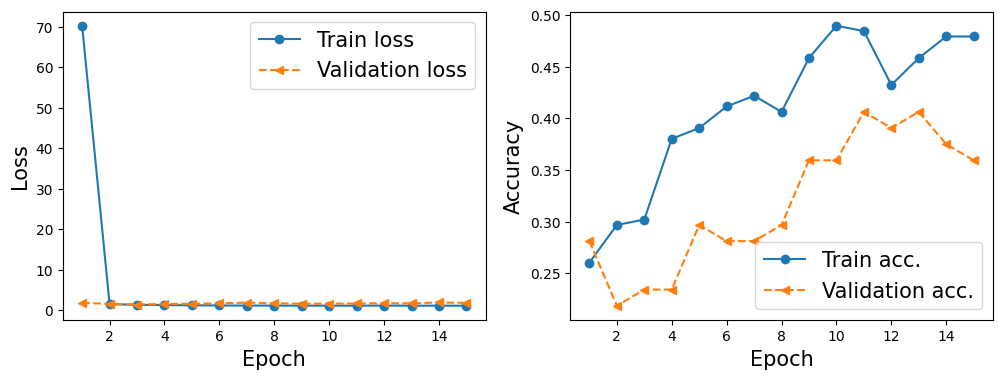

In [47]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [51]:
test_results = model_kmeans.evaluate(x={
    'Images': X_test,
    'KMeans_Labels': labels_test
    }, y=y_test_dense)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

2/2 [==============================] - 6s 3s/step - loss: 1.4852 - accuracy: 0.2188

Test Acc. 21.88%
